In [26]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import random


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchvision.transforms.functional import to_pil_image

from sklearn.metrics import confusion_matrix

### Define data augmentation

In [27]:
def data_augmentation(rot=25, crop=True, hflip=True, vflip=True):
    
    transform_list = []
    
    # if rot:
    #     transform_list.append(transforms.RandomRotation(rot))
    # if hflip:
    #     transform_list.append(transforms.RandomHorizontalFlip())

    transform_list.append(transforms.ToTensor())
    transform_list.append(transforms.Normalize((0.1307,), (0.3081,)))

    return transforms.Compose(transform_list)

### Define dataset

In [28]:
class FashionMNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        data = csv_file.values
        self.labels = data[:, 0]
        self.images = data[:, 1:].reshape(-1, 28, 28).astype(np.uint8)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        image = self.images[idx]
        image = Image.fromarray(image)  # Convert numpy to PIL

        if self.transform:
            image = self.transform(image)

        return image, label

### Load data

In [29]:
train_csv = pd.read_csv("../../Data/fashion-mnist_train.csv")
test_csv = pd.read_csv("../../Data/fashion-mnist_test.csv")
train_set = FashionMNISTDataset(train_csv, transform = data_augmentation())
test_set = FashionMNISTDataset(test_csv, transform = data_augmentation())

train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size
train_set, val_set = random_split(train_set, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)
val_loader = DataLoader(val_set, batch_size = 32, shuffle=True)

print("Train set size:", len(train_set))
print("Validation set size:", len(val_set))
print("Test set size:", len(test_set))

Train set size: 48000
Validation set size: 12000
Test set size: 10000


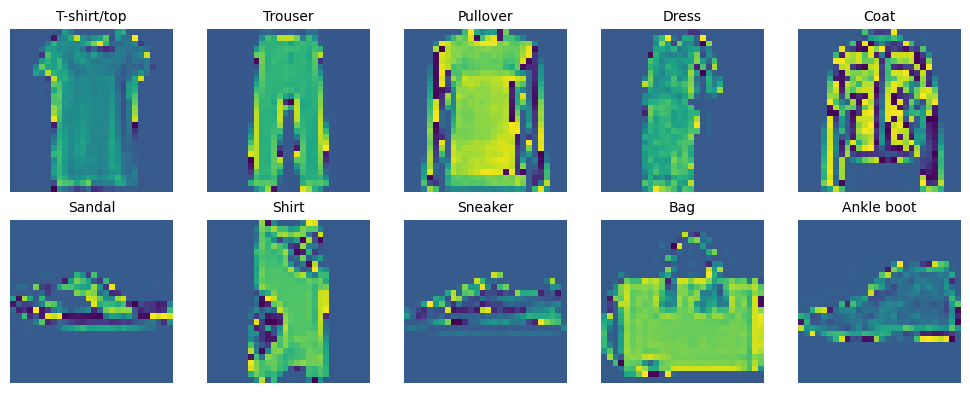

In [30]:
# Class mapping
class_names = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

def show_one_per_class(dataset, class_names=None, num_classes=None, rows=2, cols=5):

    seen = {}
    indices = list(range(len(dataset)))
    random.shuffle(indices)

    for idx in indices:
        _, label = dataset[idx]
        label = int(label)
        if label not in seen:
            seen[label] = idx
        if num_classes and len(seen) >= num_classes:
            break

    # Sort the labels for consistent display
    sorted_items = sorted(seen.items(), key=lambda x: x[0])
    total = len(sorted_items)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()

    for i, (label, idx) in enumerate(sorted_items):
        image, _ = dataset[idx]

        if isinstance(image, torch.Tensor):
            image = image.clone()
            image = image * 0.5 + 0.5  # Unnormalize if needed
            image = to_pil_image(image)

        axes[i].imshow(image)
        axes[i].set_title(class_names[label] if class_names else f"Class {label}", fontsize=10)
        axes[i].axis("off")

    for j in range(total + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

show_one_per_class(train_set, list(class_names.values()))

In [31]:
# CNN + Skip Connections + Transformer
# Skip Connections: Used to improve gradient flow, feature reuse and training stability
# Transformer: Used to capture long-range dependencies, contextual relationships and feature interactions

class DNNv3(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # CNN backbone with BatchNorm and deeper conv
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.skip1 = nn.Conv2d(32, 64, 1)
        self.pool1 = nn.MaxPool2d(2, 2)  # → 14x14

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.skip2 = nn.Conv2d(64, 128, 1)
        self.pool2 = nn.MaxPool2d(2, 2)  # → 7x7

        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.proj = nn.Conv2d(128, 128, kernel_size=1)
        self.pos_embedding = nn.Parameter(torch.randn(1, 49, 128))

        # Slightly deeper transformer
        encoder_layer = TransformerEncoderLayer(d_model=128, nhead=8, dim_feedforward=256, batch_first=True)
        self.transformer = TransformerEncoder(encoder_layer, num_layers=2)
        self.norm = nn.LayerNorm(128)

        # Classifier
        self.fc1 = nn.Linear(128, 256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x2 = x2 + self.skip1(x1)
        x2 = self.pool1(x2)

        x3 = self.conv3(x2)
        skip_x2 = self.skip2(x2)
        x3 = self.pool2(x3)
        skip_x2 = self.pool2(skip_x2)
        x3 = F.relu(x3 + skip_x2)

        x3 = self.conv4(x3)
        x3 = self.proj(x3)
        x3 = x3.flatten(2).transpose(1, 2)  # (B, 49, 128)
        x3 = self.norm(x3 + self.pos_embedding[:, :49])
        x3 = self.transformer(x3)
        x3 = x3.mean(dim=1)

        x3 = self.dropout1(F.relu(self.fc1(x3)))
        return self.fc2(x3)



### Define hyperparameters

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = DNNv3()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
epoch = 15 # Was set by many trials -> Descent performance in train/test but not overfitted
model.to(device)

cuda


DNNv3(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (skip1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (skip2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Sequential(
    (0): Conv2d(1

### Model Training

In [33]:
DEVICE = ("cuda" if torch.cuda.is_available() else "cpu")
for epochs in range(epoch):
    loss_ep = 0

    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        ## Forward Pass
        optimizer.zero_grad()
        scores = model(data)
        loss = criterion(scores,targets)
        loss.backward()
        optimizer.step()
        loss_ep += loss.item()
    print(f"Epoch {epochs+1} ] Loss : {loss_ep/len(train_loader):.6f}")

    with torch.no_grad():
        num_correct = 0
        num_samples = 0
        for batch_idx, (data,targets) in enumerate(val_loader):
            data = data.to(DEVICE)
            targets = targets.to(DEVICE)
            ## Forward Pass
            scores = model(data)
            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
        print(f"Epoch {epochs+1} ] Validation Accuracy : {float(num_correct) / float(num_samples) * 100:.2f}%")

Epoch 1 ] Loss : 0.730173
Epoch 1 ] Validation Accuracy : 84.82%
Epoch 2 ] Loss : 0.362869
Epoch 2 ] Validation Accuracy : 89.03%
Epoch 3 ] Loss : 0.292345
Epoch 3 ] Validation Accuracy : 90.44%
Epoch 4 ] Loss : 0.248362
Epoch 4 ] Validation Accuracy : 89.78%
Epoch 5 ] Loss : 0.219418
Epoch 5 ] Validation Accuracy : 91.07%
Epoch 6 ] Loss : 0.190415
Epoch 6 ] Validation Accuracy : 91.92%
Epoch 7 ] Loss : 0.168139
Epoch 7 ] Validation Accuracy : 91.92%
Epoch 8 ] Loss : 0.148006
Epoch 8 ] Validation Accuracy : 91.68%
Epoch 9 ] Loss : 0.132980
Epoch 9 ] Validation Accuracy : 91.76%
Epoch 10 ] Loss : 0.116147
Epoch 10 ] Validation Accuracy : 91.38%
Epoch 11 ] Loss : 0.102082
Epoch 11 ] Validation Accuracy : 91.92%
Epoch 12 ] Loss : 0.091663
Epoch 12 ] Validation Accuracy : 90.63%
Epoch 13 ] Loss : 0.080097
Epoch 13 ] Validation Accuracy : 91.99%
Epoch 14 ] Loss : 0.075266
Epoch 14 ] Validation Accuracy : 91.67%
Epoch 15 ] Loss : 0.067173
Epoch 15 ] Validation Accuracy : 92.16%


### Model evaluation

In [34]:
model.eval()
correct = total = 0

with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(test_loader):
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        scores = model(data)
        _, predictions = scores.max(1)
        correct += (predictions == targets).sum().item()
        total += targets.size(0)

print(f"Test Accuracy: {correct / total * 100:.2f}%")

Test Accuracy: 92.08%


In [35]:
all_preds = []
all_probs = []
all_labels = []

model.eval()
with torch.no_grad():
    for data, labels in test_loader:
        data = data.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(data)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

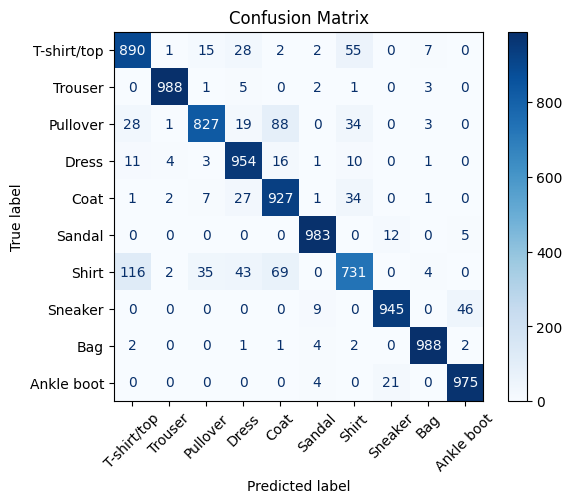

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_names.values()))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

In [37]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=list(class_names.values())))

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.85      0.89      0.87      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.93      0.83      0.88      1000
       Dress       0.89      0.95      0.92      1000
        Coat       0.84      0.93      0.88      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.84      0.73      0.78      1000
     Sneaker       0.97      0.94      0.96      1000
         Bag       0.98      0.99      0.98      1000
  Ankle boot       0.95      0.97      0.96      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [38]:
topk = 3
topk_correct = 0
total = 0

model.eval()
with torch.no_grad():
    for data, labels in test_loader:
        data = data.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(data)
        _, topk_preds = outputs.topk(topk, dim=1)  # [batch, topk]
        match = topk_preds.eq(labels.view(-1, 1))  # [batch, topk]

        topk_correct += match.any(dim=1).sum().item()
        total += labels.size(0)

topk_acc = topk_correct / total * 100
print(f"Top-{topk} Accuracy: {topk_acc:.2f}%")

Top-3 Accuracy: 99.26%


In [39]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# One-hot encode labels
y_true_bin = label_binarize(all_labels, classes=list(range(10)))
roc_auc = roc_auc_score(y_true_bin, all_probs, average="macro", multi_class="ovr")
print(f"Multiclass ROC-AUC (macro avg): {roc_auc:.4f}")

Multiclass ROC-AUC (macro avg): 0.9952
